In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from scipy import stats
from torch import Tensor

from bayesian_stats.mcmc import run_mcmc

# Beta-binomial example
What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?

We'll set our prior to convey significant skepticism the coin is biased: $P(heads) \sim beta(a=100, b=100)$

## Analytic solution using beta-binomial conjugate

P(heads) > 52.5% after observing 140 heads out of 250 flips: 63.91%


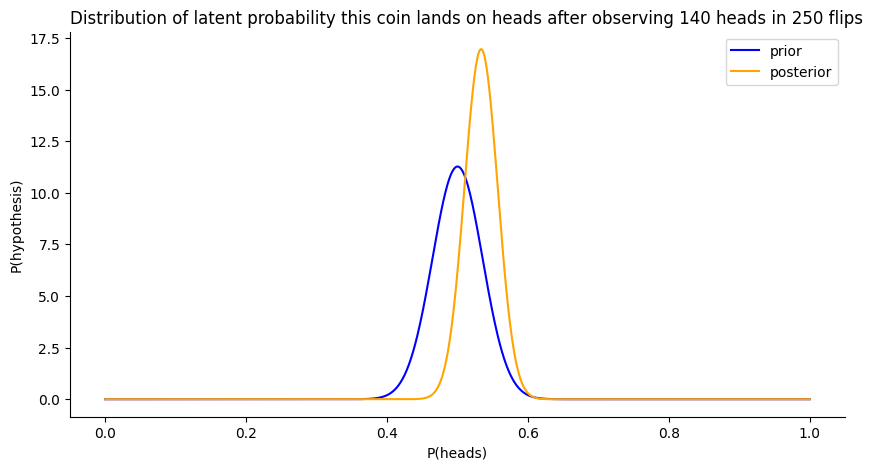

In [2]:
prior = stats.beta(a=100, b=100)
posterior = stats.beta(a=100 + 140, b=100 + 250 - 140)
print(f"P(heads) > 52.5% after observing 140 heads out of 250 flips: {1 - posterior.cdf(0.525):.2%}")

_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 1001)
ax.plot(p_heads, prior.pdf(p_heads), label="prior", color="blue")
ax.plot(p_heads, posterior.pdf(p_heads), label="posterior", color="orange")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent probability this coin lands on heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()

## Approximate solution using MCMC

In [3]:
def prior(a: float, b: float, p: Tensor) -> Tensor:
    return dist.Beta(a, b).log_prob(p)

def likelihood(p: Tensor, n: int, k: int) -> Tensor:
    return dist.Binomial(total_count=n, probs=p).log_prob(torch.tensor(k))

result = run_mcmc(
    parameter_bounds=dict(p=(0., 1.)),
    prior=partial(prior, a=100, b=100),
    likelihood=partial(likelihood, n=250, k=140),
    num_samples=2**10,
    max_iter=1_000,
    tol=1e-4,
)

### Diagnostic plots

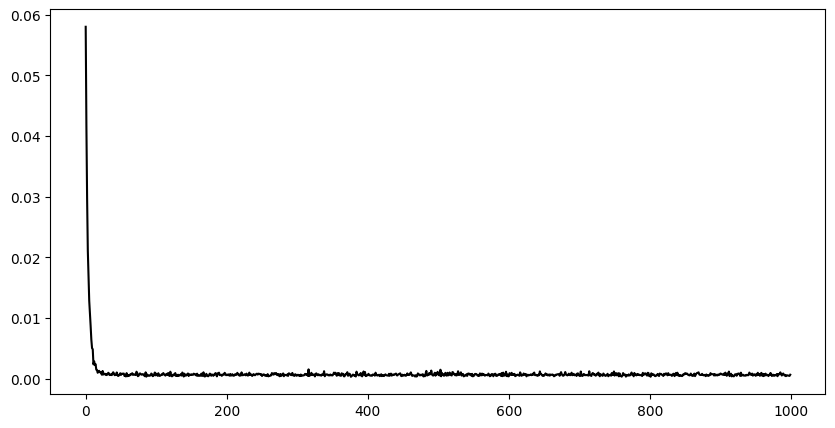

In [4]:
_, ax = plt.subplots(figsize=(10,5))
ax.plot(result.wasserstein_distance_trace[:,0], color="black")

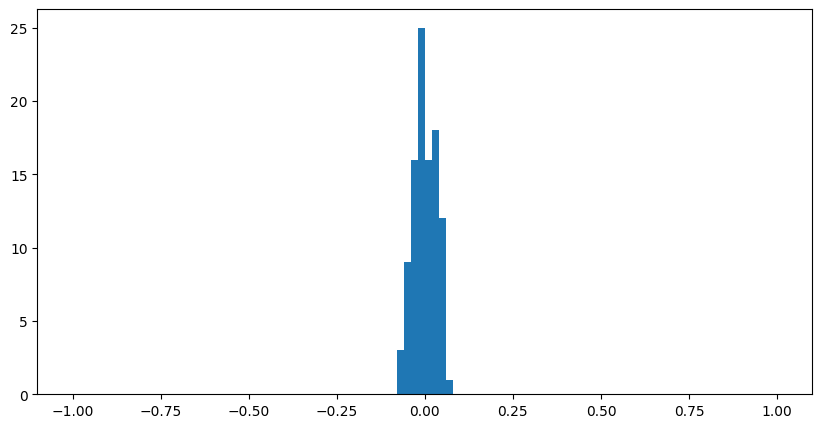

In [5]:
corr_to_init = result.get_correlation_to_init()
_, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(corr_to_init["p"], bins=torch.linspace(-1, 1, 101))

(1.0, 1000.0)

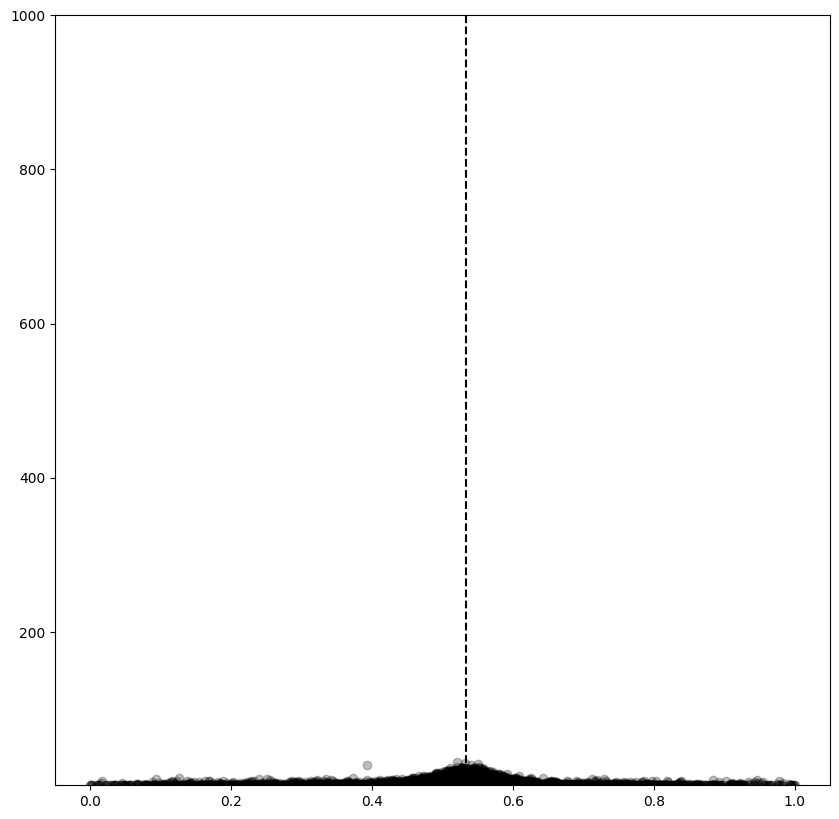

In [6]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    result.sample_counter["p"].keys(),
    result.sample_counter["p"].values(),
    alpha=0.25,
    color="black",
)
ax.axvline(x=result.get_map_estimate("p"), label="MAP estimate", color="black", linestyle="--")
ax.set_ylim(1, result.num_iter)

### $P(heads) > 52.5\%$ using MCMC samples

P(heads) > 52.5% after observing 140 heads out of 250 flips: 63.87%


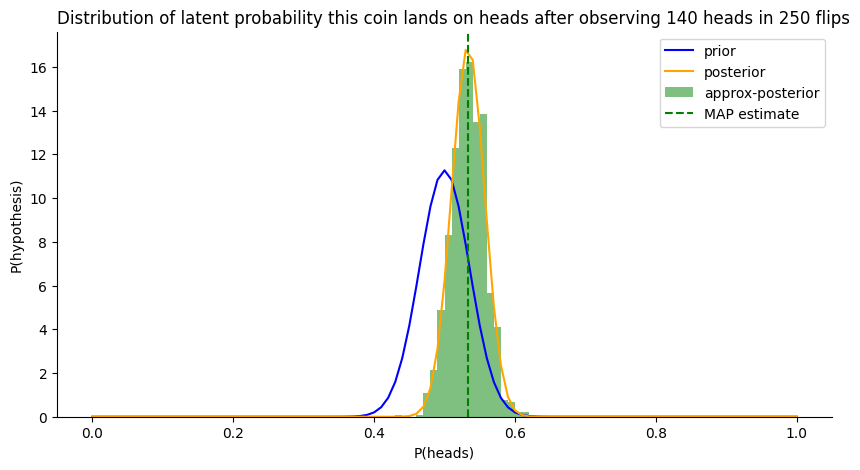

In [7]:
prior = stats.beta(a=100, b=100)
posterior = stats.beta(a=100 + 140, b=100 + 250 - 140)
print(f"P(heads) > 52.5% after observing 140 heads out of 250 flips: {(result.get_samples('p') > 0.525).numpy().mean():.2%}")

_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 101)
ax.plot(p_heads, prior.pdf(p_heads), label="prior", color="blue")
ax.plot(p_heads, posterior.pdf(p_heads), label="posterior", color="orange")
ax.hist(result.get_samples("p"), bins=p_heads, density=True, label="approx-posterior", color="green", alpha=0.5)
ax.axvline(x=result.get_map_estimate("p"), label="MAP estimate", color="green", linestyle="--")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent probability this coin lands on heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()

# Gamma-Poisson Example

You and your kid want to estimate how many pieces of candy, on average, a trick-or-treater collects from each house they visit. You both think the average is probably 2, but you also think there is a reasonable chance it could be materially higher than that. A $candy\_rate \sim Gamma(1, 0.5)$ is a reasonable reflection of your prior beliefs.

After visiting `5` houses, your kid has collected `[1, 6, 4, 2, 5]` pieces of candy; what's your updated belief of what the latent `candy_rate` is?

## Analytic solution using gamma-poisson conjugate

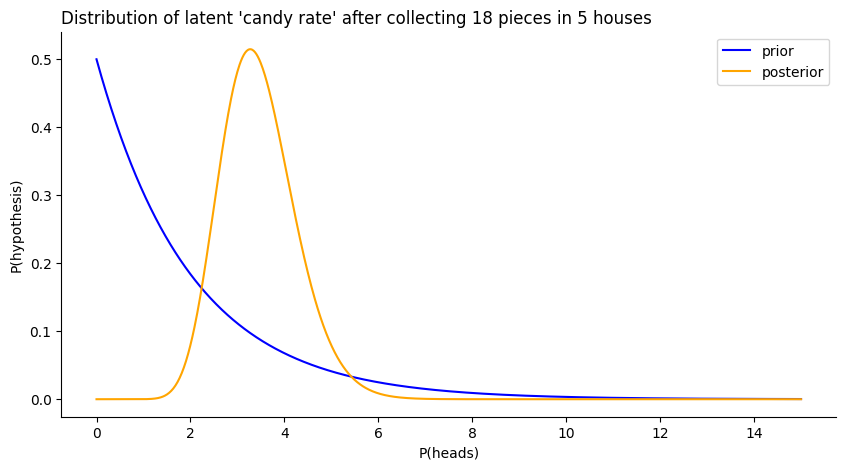

In [8]:
prior = dist.Gamma(concentration=1, rate=0.5)
obs = [1, 6, 4, 2, 5]
posterior = dist.Gamma(concentration=1 + sum(obs), rate=0.5 + len(obs))

_, ax = plt.subplots(figsize=(10,5))

candy_rate = torch.linspace(0, 15, 1001)
ax.plot(candy_rate, torch.exp(prior.log_prob(candy_rate)), label="prior", color="blue")
ax.plot(candy_rate, torch.exp(posterior.log_prob(candy_rate)), label="posterior", color="orange")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent 'candy rate' after collecting 18 pieces in 5 houses",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()

## Approximate solution using MCMC

In [9]:
def prior(concentration: float, rate: float, candy_rate: Tensor) -> Tensor:
    return dist.Gamma(concentration, rate).log_prob(candy_rate)

def likelihood(candy_rate: Tensor, obs: list[int]) -> Tensor:
    return dist.Poisson(rate=candy_rate * len(obs)).log_prob(torch.tensor(sum(obs)))

result = run_mcmc(
    parameter_bounds=dict(candy_rate=(0., 20.)),
    prior=partial(prior, concentration=1.0, rate=0.5),
    likelihood=partial(likelihood, obs=[1, 6, 4, 2, 5]),
    num_samples=2**10,
    max_iter=1_000,
    tol=1e-4,
)

### Diagnostic plots

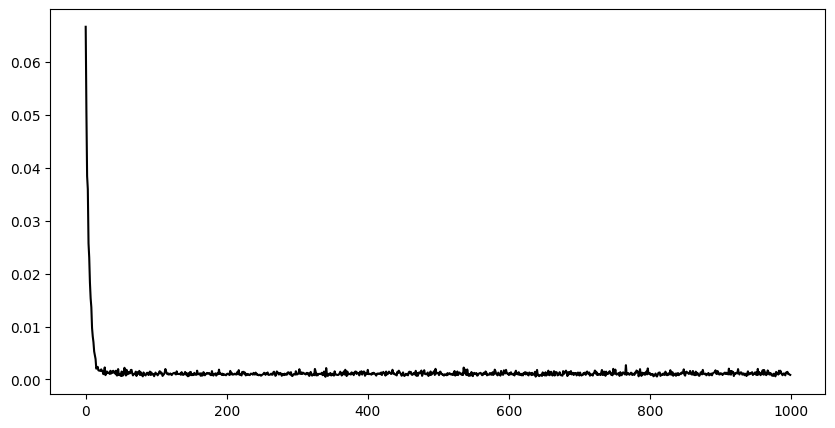

In [10]:
_, ax = plt.subplots(figsize=(10,5))
ax.plot(result.wasserstein_distance_trace[:,0], color="black")

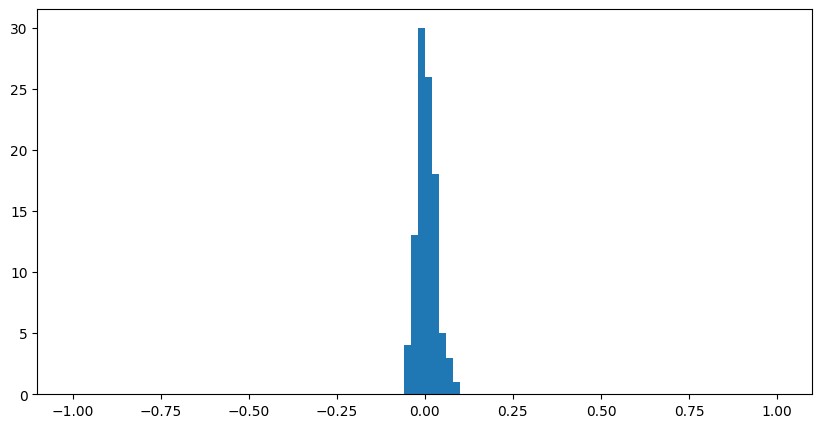

In [11]:
corr_to_init = result.get_correlation_to_init()
_, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(corr_to_init["candy_rate"], bins=torch.linspace(-1, 1, 101))

(1.0, 1000.0)

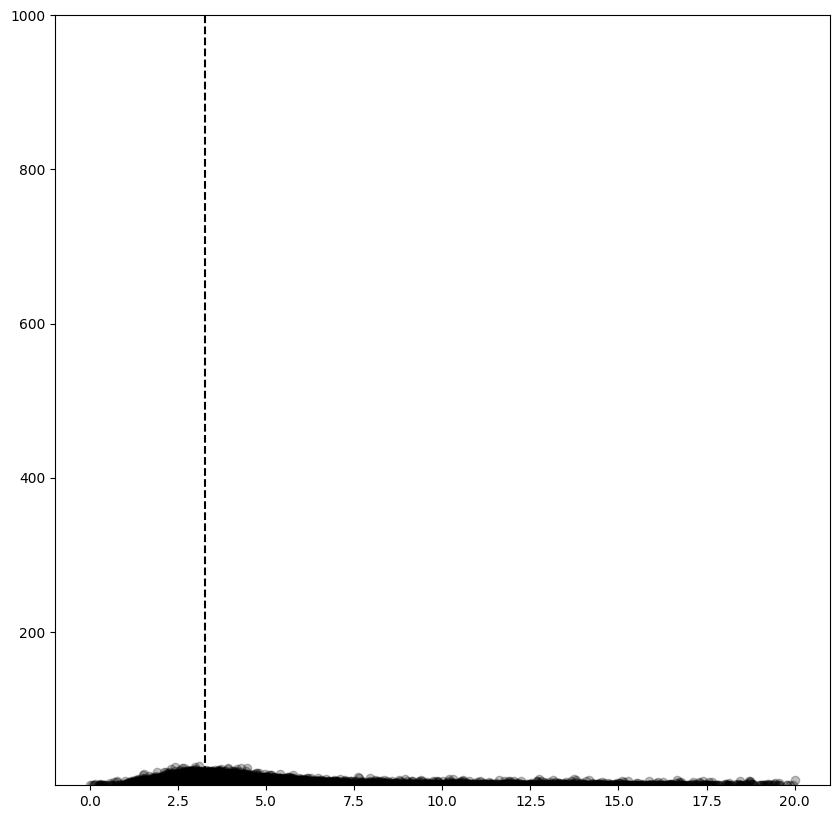

In [12]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    result.sample_counter["candy_rate"].keys(),
    result.sample_counter["candy_rate"].values(),
    alpha=0.25,
    color="black",
)
ax.axvline(x=result.get_map_estimate("candy_rate"), label="MAP estimate", color="black", linestyle="--")
ax.set_ylim(1, result.num_iter)

### Posterior analysis using MCMC samples

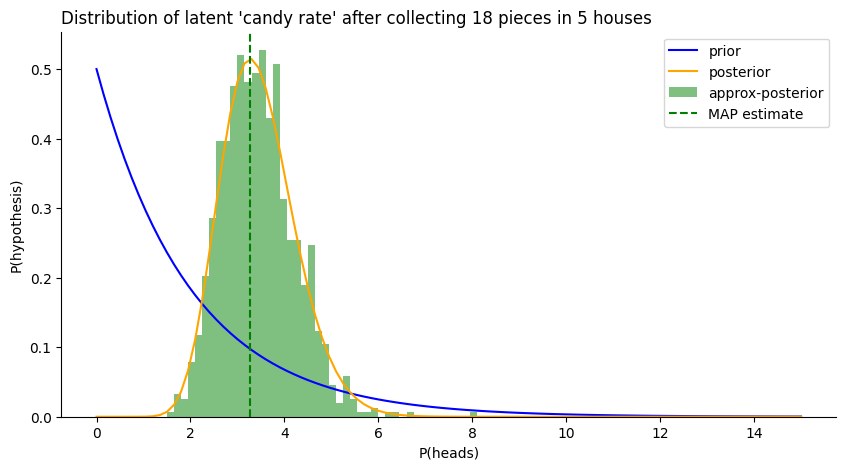

In [13]:
prior = dist.Gamma(concentration=1, rate=0.5)
obs = [1, 6, 4, 2, 5]
posterior = dist.Gamma(concentration=1 + sum(obs), rate=0.5 + len(obs))

_, ax = plt.subplots(figsize=(10,5))

candy_rate = torch.linspace(0, 15, 101)
ax.plot(candy_rate, torch.exp(prior.log_prob(candy_rate)), label="prior", color="blue")
ax.plot(candy_rate, torch.exp(posterior.log_prob(candy_rate)), label="posterior", color="orange")
ax.hist(result.get_samples("candy_rate"), bins=candy_rate, density=True, label="approx-posterior", color="green", alpha=0.5)
ax.axvline(x=result.get_map_estimate("candy_rate"), label="MAP estimate", color="green", linestyle="--")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent 'candy rate' after collecting 18 pieces in 5 houses",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()